In [1]:
from copy import deepcopy
from collections import defaultdict
import os
import math

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as skd
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

from simple_nnnet import SimpleTwoLayerNet, create_nnnet
from sklearn.utils import check_random_state
from utils import EarlyStopping

mpl.rcParams["mathtext.fontset"] = "cm"

In [2]:
def get_moons(n_samples_per_moon, noise=0.1, random_state=0):
    moons_data, moons_labels = skd.make_moons(
        (n_samples_per_moon, n_samples_per_moon),
        shuffle=False, noise=noise, random_state=random_state)
    first_class = pd.DataFrame(moons_data[:n_samples_per_moon,:], columns=["x","y"])
    second_class = pd.DataFrame(moons_data[n_samples_per_moon:,:], columns=["x","y"])
    first_class["label"] = 0
    second_class["label"] = 1
    df = pd.concat((first_class, second_class), axis=0)
    return df

In [3]:
n_train = 100
n_val = 20
rng = check_random_state(0)
train_df = get_moons(n_train, random_state=rng)
val_df = get_moons(n_val, random_state=rng)

X = torch.tensor(train_df[["x", "y"]].values).float()
y = torch.tensor(train_df.label.values)

In [4]:
# Define hyperparameters
n_input_dim = 2
n_protos_list = [2, 16, 128]
n_classes = len(train_df.label.unique())
n_epochs = 25
batch_size = 10
lr = 0.01
verbose = False
method = "neglog-dist"
eps = 1e-3
power = 2

train_input = torch.from_numpy(train_df[["x", "y"]].values).float()
train_target = torch.from_numpy(train_df.label.astype(int).values)
val_input = torch.from_numpy(val_df[["x", "y"]].values).float()
val_target = torch.from_numpy(val_df.label.astype(int).values)

xyts = [
    ("(-1, 1) -> 1", (-1., 1., 1)),
    ("(-1, 1) -> 0", (-1., 1., 0)),
    ("(0, 1) -> 1", (0., 1., 1)),
    ("(0, 1) -> 0", (0., 1., 0)),
    ("(1, 0) -> 1", (1., 0., 1)), 
    ("(1, 0) -> 0", (1., 0., 0)),
]
results_dict = defaultdict(lambda: dict())  # xytname -> n_protos -> (train_pred, val_pred, train_acc, val_acc) 

everaugmented = False
for n_protos in n_protos_list:
    model = create_nnnet(X=X, y=y, n_protos=n_protos, method=method, eps=eps, power=power)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    early_stopping = EarlyStopping(patience=5)

    for epoch in range(n_epochs):    
        model.train()
        shuffle_idx = torch.randperm(train_input.size()[0])
        shuffled_input = train_input[shuffle_idx]
        shuffled_target = train_target[shuffle_idx]
        train_loss = 0.
        for batch_idx in range(0, len(train_input), batch_size):
            x = shuffled_input[batch_idx: batch_idx + batch_size]
            y = shuffled_target[batch_idx: batch_idx + batch_size]
            output = model(x)
            loss = criterion(output, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        model.eval()
        val_loss = 0.
        for batch_idx in range(0, len(val_input), batch_size):
            x = val_input[batch_idx: batch_idx + batch_size]
            y = val_target[batch_idx: batch_idx + batch_size]
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
    
        scheduler.step()
        early_stopping(val_loss, model, epoch)
        #if early_stopping.early_stop:
        #    print("early stop")
        #    break
        if verbose:
            print(
                f"Epoch {epoch}, Train Loss {train_loss/len(train_input):4f},"
                f"Val Loss {val_loss/len(val_input):4f}")

    train_pred = []
    for batch_idx in range(0, len(train_input), batch_size):
        x = train_input[batch_idx: batch_idx + batch_size]
        y = train_target[batch_idx: batch_idx + batch_size]
        output = model(x)
        pred_list = output.argmax(dim=-1).tolist()
        train_pred.extend(pred_list)
    train_pred = np.array(train_pred)  
    val_pred = []
    for batch_idx in range(0, len(val_input), batch_size):
        x = val_input[batch_idx: batch_idx + batch_size]
        y = val_target[batch_idx: batch_idx + batch_size]
        output = model(x)
        val_list = output.argmax(dim=-1).tolist()
        val_pred.extend(val_list)
    val_pred = np.array(val_pred)

    for xytix, (xytname, xyt) in enumerate(xyts):
        idx = -1 if everaugmented else None
        xyt_input = torch.tensor([[xyt[0], xyt[1]]]).float()
        print(xyt_input)
        xyt_target = xyt[2]
        model.augment(xyt_input, xyt_target, idx=idx, verbose=True)
        everaugmented = True
        train_pred_after = []
        for batch_idx in range(0, len(train_input), batch_size):
            x = train_input[batch_idx: batch_idx + batch_size]
            y = train_target[batch_idx: batch_idx + batch_size]
            output = model(x)
            pred_list = output.argmax(dim=-1).tolist()
            train_pred_after.extend(pred_list)
        train_pred_after = np.array(train_pred_after)
        
        val_pred_after = []
        for batch_idx in range(0, len(val_input), batch_size):
            x = val_input[batch_idx: batch_idx + batch_size]
            y = val_target[batch_idx: batch_idx + batch_size]
            output = model(x)
            val_list = output.argmax(dim=-1).tolist()
            val_pred_after.extend(val_list)
        val_pred_after = np.array(val_pred_after)
        
        results_dict[xytname][n_protos] = (deepcopy(model), train_pred, val_pred, train_pred_after, val_pred_after)

tensor([[-1.,  1.]])
Fixing with new key-value:1.8561
tensor([[-1.,  1.]])
Replacing -1 key-value:3.7069
tensor([[0., 1.]])
Replacing -1 key-value:2.8744
tensor([[0., 1.]])
Replacing -1 key-value:5.6548
tensor([[1., 0.]])
Replacing -1 key-value:0.0091
tensor([[1., 0.]])
Replacing -1 key-value:0.0238
tensor([[-1.,  1.]])
Replacing -1 key-value:2.3141
tensor([[-1.,  1.]])
Replacing -1 key-value:4.5324
tensor([[0., 1.]])
Replacing -1 key-value:2.9041
tensor([[0., 1.]])
Replacing -1 key-value:5.3698
tensor([[1., 0.]])
Replacing -1 key-value:1.1780
tensor([[1., 0.]])
Replacing -1 key-value:2.1842
tensor([[-1.,  1.]])
Replacing -1 key-value:2.6041
tensor([[-1.,  1.]])
Replacing -1 key-value:4.2090
tensor([[0., 1.]])
Replacing -1 key-value:3.7384
tensor([[0., 1.]])
Replacing -1 key-value:4.2733
tensor([[1., 0.]])
Replacing -1 key-value:0.2975
tensor([[1., 0.]])
Replacing -1 key-value:0.3716


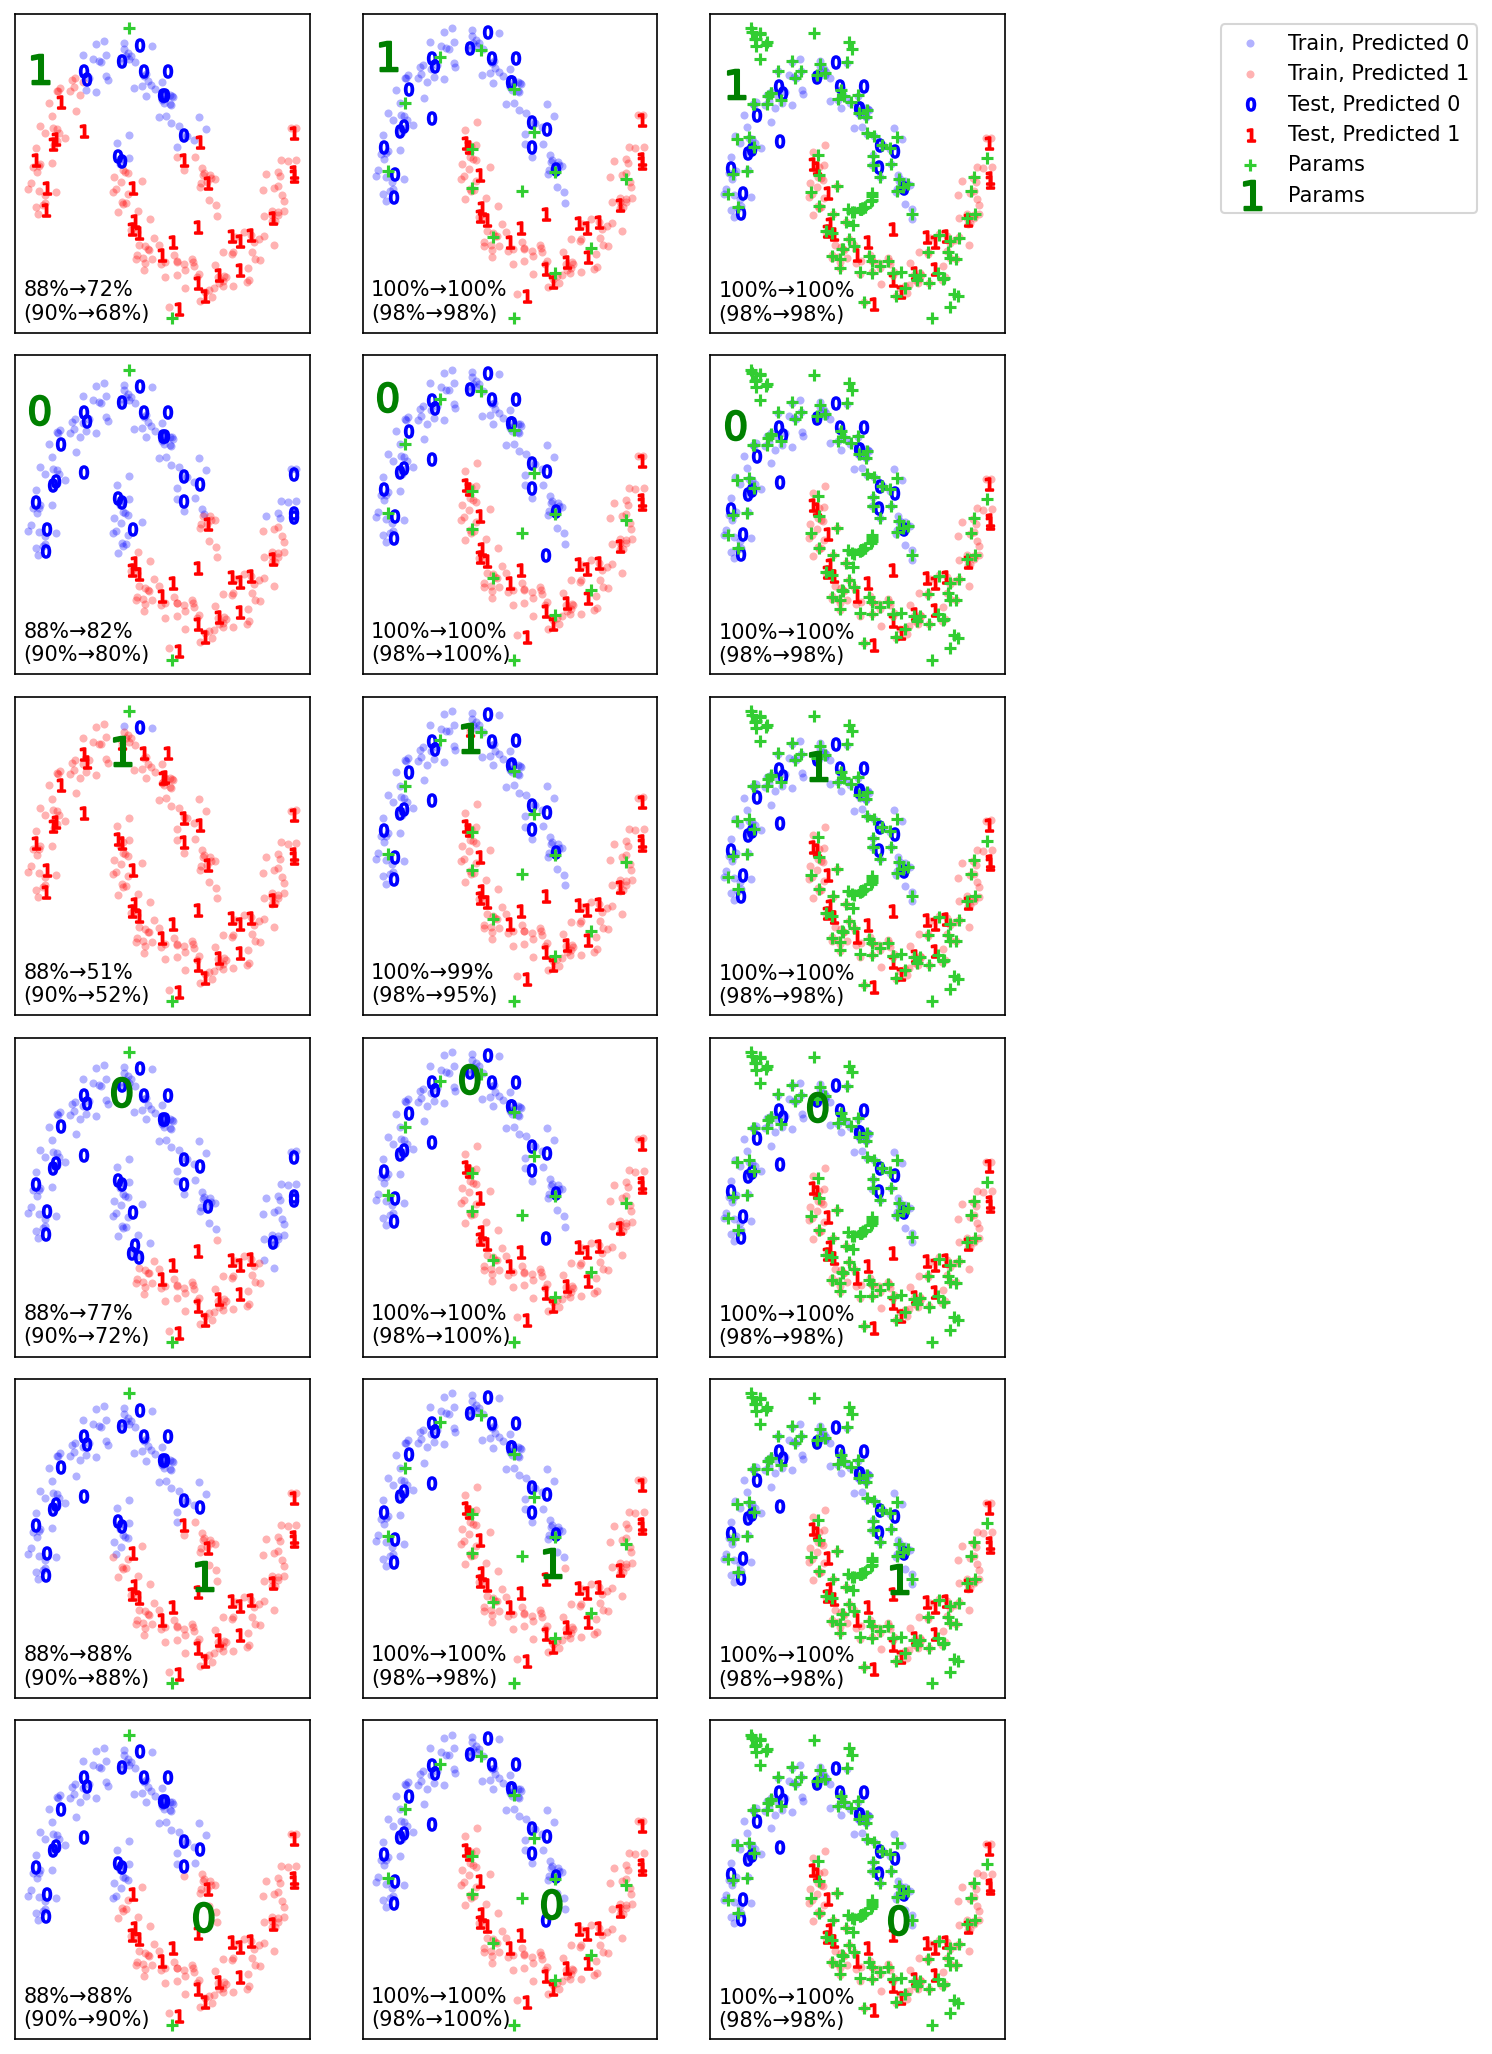

In [14]:
fig, axes = plt.subplots(
    nrows=len(xyts), ncols=len(n_protos_list),
    figsize=(2.3*len(n_protos_list),2.3*len(xyts)), dpi=150);
for mix in range(len(xyts)):
    mname, xyt = xyts[mix]
    targetval = xyt[2]
    for pix in range(len(n_protos_list)):
        n_protos = n_protos_list[pix]
        (model, train_pred, val_pred, train_pred_after, val_pred_after) = results_dict[mname][n_protos]
        train_acc = np.mean(train_pred == train_target.numpy())
        val_acc = np.mean(val_pred == val_target.numpy())
        train_acc_after = np.mean(train_pred_after == train_target.numpy())
        val_acc_after = np.mean(val_pred_after == val_target.numpy())
        keys_np = model.keys.detach().numpy()
        
        axes[mix, pix].scatter(
            train_input[train_pred_after == 0][:, 0], train_input[train_pred_after == 0][:, 1],
            marker='o', linewidth=0, s=15, c='blue', alpha=0.3,
            label='Train, Predicted 0');
        axes[mix, pix].scatter(
            train_input[train_pred_after == 1][:, 0], train_input[train_pred_after == 1][:, 1],
            marker='o', linewidth=0, s=15, c='red', alpha=0.3,
            label='Train, Predicted 1');
        axes[mix, pix].scatter(
            val_input[val_pred_after == 0][:, 0], val_input[val_pred_after == 0][:, 1],
            marker='$0$', c='blue', label='Test, Predicted 0');
        axes[mix, pix].scatter(
            val_input[val_pred_after == 1][:, 0], val_input[val_pred_after == 1][:, 1],
            marker='$1$', c='red', label='Test, Predicted 1');
        axes[mix, pix].scatter(
            keys_np[:-1, 0], keys_np[:-1, 1],
            marker='+', c='limegreen', label='Params');
        axes[mix, pix].scatter(
            keys_np[-1:, 0], keys_np[-1:, 1],
            marker=f"${targetval}$", c='green', s=200, label='Params');
        axes[mix, pix].text(
            axes[mix, pix].get_xlim()[0]+0.1, axes[mix, pix].get_ylim()[0]+0.1,
            f"{train_acc:.0%}→{train_acc_after:.0%}\n({val_acc:.0%}→{val_acc_after:.0%})",
            color="black", fontsize=10)
        #if pix == 1:
        #    axes[mix, pix].set_title(mname);
        axes[mix, pix].set_xticks([]);
        axes[mix, pix].set_yticks([]);
        axes[mix, pix].tick_params(top=False, bottom=False, left=False, right=False);
        if mix == 0 and pix == 0:
            axes[mix, pix].legend();
plt.tight_layout();
fig.patch.set_facecolor('white');
sns.move_legend(axes[0, 0], "upper right", bbox_to_anchor=(5.0, 1.0), title="")
plt.savefig(f'moons-lowimpact-{n_train}-{n_val}.pdf');